In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model
from fourparam_fit import xi_bestfit, fit_to_cf_model

## a single lognormal fit: loaded results

In [2]:
rlz = 4

In [3]:
data_dir = '/scratch/aew492/research-summer2020_output'
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
mock_name = f'{cat_tag}_rlz{rlz}_lognormal'

# other parameters
rmin = 20.0
rmax = 140.0

In [4]:
# binned results
ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{mock_name}.npy'), allow_pickle=True)
r_avg = ls_results[0]
xi_ls = ls_results[1]

In [5]:
# 4-parameter fit results
fit_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
B_sq = fit_results['B_sq']
a1 = fit_results['a1']
a2 = fit_results['a2']
a3 = fit_results['a3']
bestfit_alpha = fit_results['best_alpha']
bestfit_alpha, B_sq, a1, a2, a3, B_sq.shape

(0.81,
 -0.43067958254231864,
 298.32820033330484,
 -4.3583156368667195,
 0.01781169324602769,
 ())

In [6]:
# plug recovered parameters back into xi equation
ncont = 1000
r_fine = np.linspace(rmin, rmax, ncont+1)
xi_mod_fine = cf_model(bestfit_alpha*r_fine, cosmo_base=None, redshift=0.57, bias=2.0)

xi_fit = xi_bestfit(r_fine, xi_mod_fine, B_sq, a1, a2, a3)
xi_fit.shape

(1001,)

In [7]:
# load in bao iterative
bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
rcont, bao_basis, _, _, extra_dict = bao_results
bao_alpha = extra_dict['alpha_model']

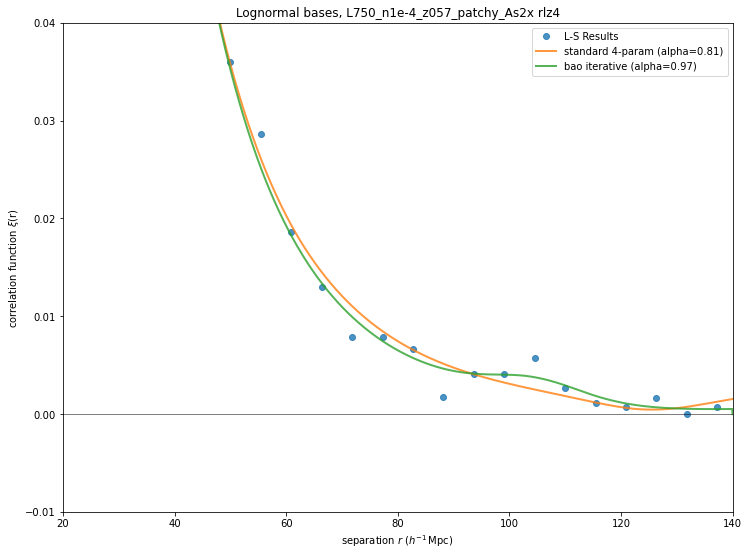

In [8]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, xi_ls, marker='o', ls='None', alpha=0.8, label=f'L-S Results')

plt.plot(r_fine, xi_fit, lw=2, alpha=0.8, label='standard 4-param (alpha={:.2f})'.format(bestfit_alpha))

plt.plot(rcont, bao_basis, lw=2, alpha=0.8, label='bao iterative (alpha={:.2f})'.format(bao_alpha))

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Lognormal bases, {cat_tag} rlz{rlz}')
plt.legend()

## a single lognormal fit: calculated here

In [9]:
# in part, calculated here in order to get the chi-squared distribution

In [10]:
# we already have binned values loaded in above
nbins = len(r_avg)

In [11]:
# find the spread (sigma) of xi in each bin; used to calculate chi-squared
nmocks = 401
xi_lss = np.empty((nmocks, nbins))

for rlz in range(nmocks):
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_lss[rlz] = ls_results[1]

    ls_std = np.std(xi_lss, axis=0)

# cov = np.cov(xi_lss.T)
# cov.shape, sigmas.shape, cov, sigmas
ls_std.shape

/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


(22,)

In [12]:
# covariance matrix– identity for now
C_id = np.identity(nbins)

cov_diag = np.diag(ls_std**2)

cov_full = np.cov(xi_lss.T)

In [13]:
# let's calculate the fit at different alpha values:
alpha_grid = np.linspace(0.75, 1.25, 51)
fit_params = np.empty((len(alpha_grid), 4))
xi_fits = np.empty((len(alpha_grid), nbins))
chi_squareds = np.ones(len(alpha_grid))
old_chi_squareds = np.ones(len(alpha_grid))
for i in range(len(alpha_grid)):
    # print(alpha_grid[i], xi_ls.shape, r_avg.shape, C_inv.shape)
    xi_fit, M = fit_to_cf_model(alpha_grid[i], xi_ls, r_avg, cov_full)
    xi_fits[i] = xi_fit
    fit_params[i] = M
    diff = xi_ls - xi_fit
    # chi_squared = np.sum(diff**2 / ls_std**2)
    chi_squared = np.dot(diff, np.linalg.solve(cov_full, diff))
    chi_squareds[i] = chi_squared

best alpha: 1.0
bao alpha: 0.97


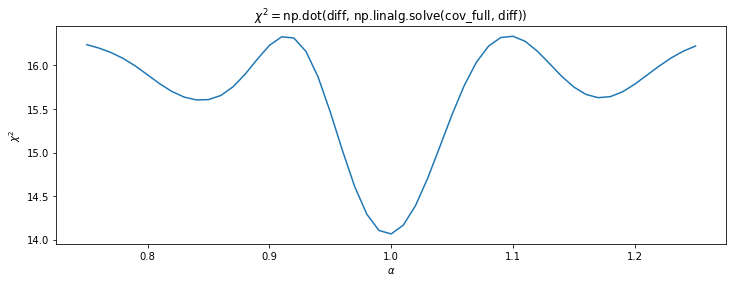

In [14]:
# plot chi_squareds as a function of alpha
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(alpha_grid, chi_squareds)
ax.set_title(f'$\chi^2 = $np.dot(diff, np.linalg.solve(cov_full, diff))')
ax.set(xlabel=r'$\alpha$', ylabel=r'$\chi^2$')

print(f"best alpha: {alpha_grid[chi_squareds.argmin()]}")
print("bao alpha: {:.2f}".format(bao_alpha))

## distribution of alphas

In [15]:
# load in alpha values
rlzs = range(401)
standard_alphas = np.ones(len(rlzs))
bao_alphas = np.ones(len(rlzs))
for rlz in rlzs:
    standard_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/full/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    standard_alpha = standard_results['best_alpha']
    standard_alphas[rlz] = standard_alpha
    
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    _, _, _, _, extra_dict = bao_results
    bao_alpha = extra_dict['alpha_model']
    bao_alphas[rlz] = bao_alpha

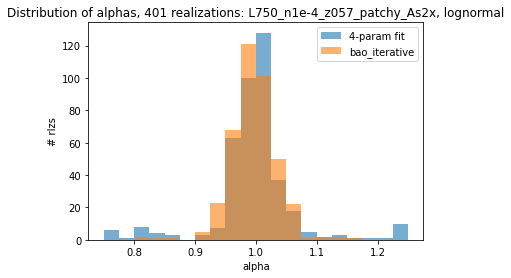

In [16]:
nbins = 20
alpha = .6
_, bins, _ = plt.hist(standard_alphas, bins=nbins, alpha=alpha, label='4-param fit')
plt.hist(bao_alphas, bins=bins, alpha=alpha, label='bao_iterative')
plt.xlabel('alpha')
plt.ylabel('# rlzs')
plt.title(f'Distribution of alphas, 401 realizations: {cat_tag}, lognormal')
plt.legend()

In [17]:
# distribution of alphas: identity covariance matrix
# load in alpha values
rlzs = range(401)
standard_alphas = np.ones(len(rlzs))
bao_alphas = np.ones(len(rlzs))
for rlz in rlzs:
    standard_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    standard_alpha = standard_results['best_alpha']
    standard_alphas[rlz] = standard_alpha
    
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    _, _, _, _, extra_dict = bao_results
    bao_alpha = extra_dict['alpha_model']
    bao_alphas[rlz] = bao_alpha

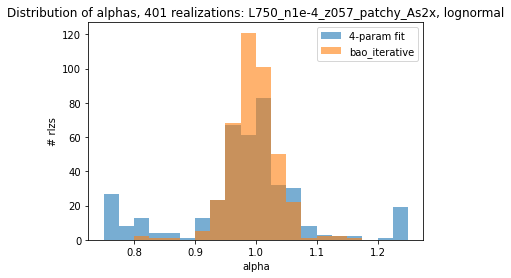

In [18]:
nbins = 20
alpha = .6
_, bins, _ = plt.hist(standard_alphas, bins=nbins, alpha=alpha, label='4-param fit')
plt.hist(bao_alphas, bins=bins, alpha=alpha, label='bao_iterative')
plt.xlabel('alpha')
plt.ylabel('# rlzs')
plt.title(f'Distribution of alphas, 401 realizations: {cat_tag}, lognormal')
plt.legend()

## compare to scipy fit

In [19]:
# redefine for clarity
nbins = 22

# other parameters
rmin = 20.0
rmax = 140.0
ncont = 1000

rfine = np.linspace(rmin, rmax, ncont+1)

In [20]:
# covariance matrix
nmocks = 401
xi_lss = np.empty((nmocks, nbins))

for rlz in range(nmocks):
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_lss[rlz] = ls_results[1]

cov = np.cov(xi_lss.T)
cov.shape

(22, 22)